## Лабораторная работа № 4
-----
### Визуальная одометрия

В данной работе предлагается реализовать алгоритм визуальной одометрии для нахождения траектории движения мобильного робота.


**В данной работе необходимо:**
- Выявить коючевые точки(признаки) на изображениях, которые были сделаны с помощью камеры, установленной на движущемся объекте.
- Использовать извлеченные признаки, чтобы найти совпадения между ними на разных фотографиях.
- Использовать найденные совпадения для оценки движения камеры между последующими фотографиями. 
- Использовать оценку движения камеры для построения траектории движения объекта.

Для большинства задач вам предоставляется рекомендуемый план. Но если вы считаете, что есть лучший и более эффективный способ решения проблемы, то можно отклоняться.

Скачивание необходимых файлов

In [2]:
!gdown 1crStkNUxzYAauelhrx_lZ__XPuVIw69a

"gdown" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [ ]:
!unrar x /content/lab4_files.rar #извекаем файлы из архива


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/lab4_files.rar

Creating    lab4_files                                                OK
Creating    lab4_files/data                                           OK
Creating    lab4_files/data/depth                                     OK
Extracting  lab4_files/data/depth/frame_00001.dat                        0  OK 
Extracting  lab4_files/data/depth/frame_00002.dat                        0  OK 
Extracting  lab4_files/data/depth/frame_00003.dat                        1  OK 
Extracting  lab4_files/data/depth/frame_00004.dat                        1  OK 
Extracting  lab4_files/data/depth/frame_00005.dat                        2  OK 
Extracting  lab4_files/data/depth/frame_00006.dat                        2  OK 
Extracting  lab4_files/data/depth/frame_00007.dat                        3  OK 
Extracting  lab4_files/data/depth/frame_00008.dat                        3  OK 
Extracting  lab4_files/data/dep

In [2]:
!python /content/lab4_files/m2bk.py

python: can't open file '/content/lab4_files/m2bk.py': [Errno 2] No such file or directory


Подключаем необходимые библиотеки

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from lab4_files.m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)


ModuleNotFoundError: No module named 'lab4_files'

## 0 - Загрузка и визуализация данных
Удобный класс обработчика набора данных для чтения и итерирования по ним доступен в локальном пакете. Данные взяты из симулятора CARLA. Запустите следующий код, чтобы создать объект обработчика набора данных.

In [ ]:
dataset_handler = DatasetHandler()

Обработчик набора данных содержит 52 кадра. Каждый кадр содержит изображение RGB и карту глубины, полученную с одинаковым интервалом времени при движении на транспортном средстве, и версию изображения RGB в градациях серого, которая будет использоваться для вычислений. 

Готовая матрица калибровки камеры **K** также хранится в обработчике набора данных.

При создании объекта обработчика набора данных все кадры будут автоматически прочитаны и загружены. Доступ к содержимому кадра можно получить с помощью аттрибутов `images`, `images_rgb`, `depth_maps` вместе с номером запрошенного кадра. Посмотрите, как получить доступ к изображениям (оттенки серого), изображениям RGB (3-канальный цвет), картам глубины и матрице калибровки камеры в приведенном ниже примере.

**Примечание (карты глубины)**: Максимальное расстояние глубины равно 1000. Это значение глубины показывает, что выбранный пиксель находится на расстоянии не менее 1000 м (1 км) от камеры, однако точное расстояние этого пикселя от камеры неизвестно. Наличие таких точек в дальнейшей оценке траектории может повлиять на точность траектории.

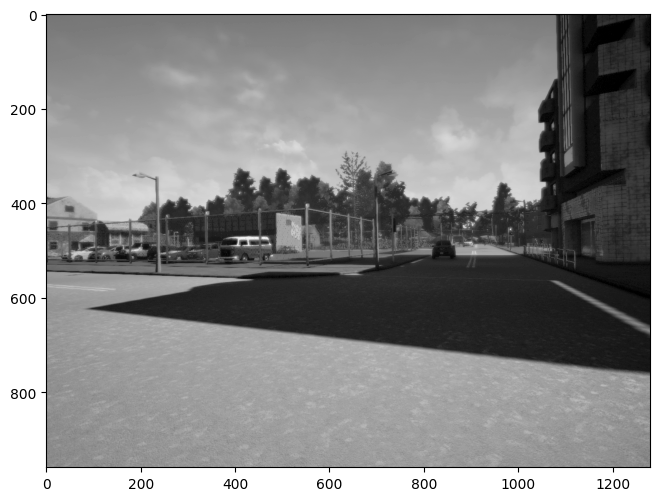

In [ ]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

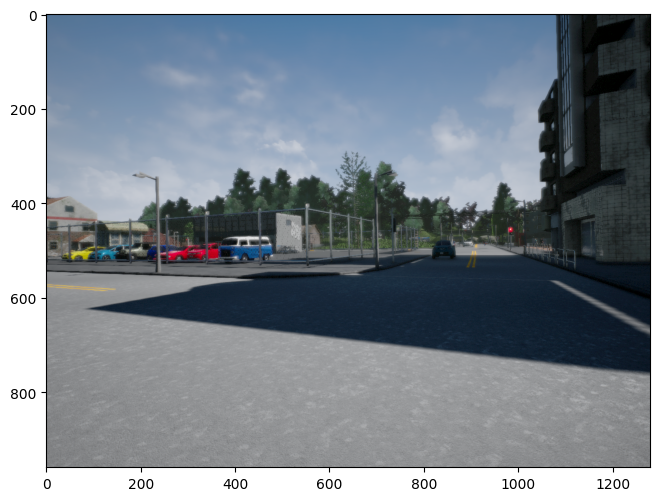

In [ ]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

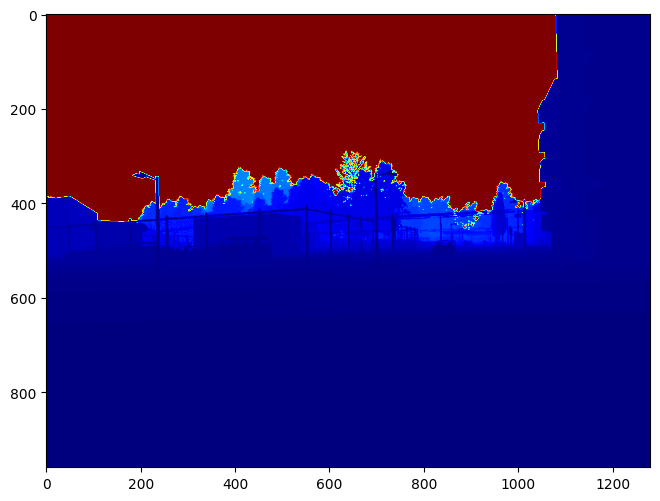

In [ ]:
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [ ]:

depth

array([[1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       [1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       [1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       ...,
       [   1.972,    1.971,    1.971, ...,    1.87 ,    1.87 ,    1.87 ],
       [   1.967,    1.967,    1.967, ...,    1.866,    1.866,    1.866],
       [   1.963,    1.963,    1.963, ...,    1.863,    1.863,    1.862]])

In [ ]:
print("Размеры карты глубин: {0}".format(depth.shape))
v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Значение глубины самого нижнего правого пикселя карты глубины кадры {0} равно {1:0.3f}".format(i, depth_val))

Размеры карты глубин: (960, 1280)
Значение глубины самого нижнего правого пикселя карты глубины кадры 0 равно 1.862


In [ ]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

Для доступа к произвольному кадру используйте индекс изображения, как показано в примерах ниже. Убедитесь, что индексы находятся в пределах количества кадров в наборе данных. Доступ к количеству кадров в наборе данных можно получить с помощью атрибута num_frames.

In [ ]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

52


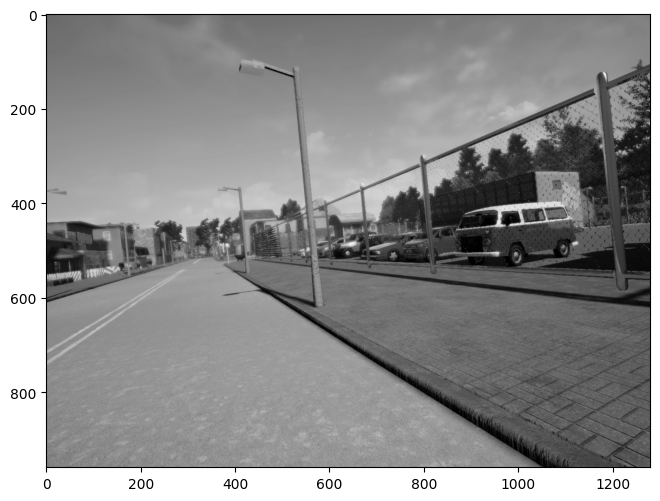

In [ ]:
i = 35
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

## 1 - Извлечение признаков

### 1.1 - Извлечение признаков из изображения

**Задание**: Реализовать извлечение признаков из одного изображения. Вы можете использовать любой дескриптор признаков по вашему выбору, например, ORB или SIFT.



***Опционально***: Попробуйте извлечь функции с разными дескрипторами, такими как SIFT, ORB, SURF и BRIEF. Вы также можете попробовать использовать детекторы, такие как углы Харриса или FAST, и соединить их с дескриптором. Наконец, попробуйте изменить параметры алгоритмов.

In [ ]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    ### START CODE HERE ### 

    
    ### END CODE HERE ###
    
    return kp, des

In [ ]:
i = 1
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

In [ ]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

In [ ]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images[i]

visualize_features(image, kp)

### 1.2 - Извлечение признаков из каждого изображения в наборе данных

**Task**: Реализуйте извлечение признаков для каждого изображения в наборе данных с помощью функции, которую вы написали в предыдущем разделе.


In [ ]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    ### START CODE HERE ###

    
    ### END CODE HERE ###
    
    return kp_list, des_list

In [ ]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 1
print("Количество признаков обнаружено в кадре {0}: {1}".format(i, len(kp_list[i])))
print("Координаты первой ключевой точки в кадре {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Длина массива изображений: {0}".format(len(images)))

## 2 - Сопоставление признаков

Следующим шагом после извлечения признаков в каждом изображении является сопоставление признаков из последующих кадров. Это то, что необходимо сделать в этом разделе.

### 2.1 - Сопоставление признаков из пары последующих кадров

**Задание**: Реализовать сопоставление признаков для пары изображений. Вы можете использовать любой алгоритм сопоставления признаков по вашему выбору, описанный в лекциях, например, Brute Force Matching или сопоставление на основе FLANN.

***Подсказка(опционально)***: Реализуйте фильтрацию совпадений, устанавливая пороговое значение расстояния между лучшими совпадениями. Это может быть полезно для улучшения общих результатов оценки траектории. Напомним, что у вас есть возможность указать количество наилучших совпадений, которые должны быть возвращены сопоставителем.

Мы предоставили визуализацию найденных совпадений. Все совпадения кажутся вам справедливыми? Считаете ли вы, что фильтрация совпадений может улучшить ситуацию?

In [ ]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###

    
    ### END CODE HERE ###

    return matches

In [ ]:
i = 0
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Количество признаков, совпадающих в кадрах {0} и {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

In [ ]:
# Optional
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    ### START CODE HERE ###

    
    ### END CODE HERE ###

    return filtered_match

In [ ]:
# Optional
i = 0
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 15
filtered_match = filter_matches_distance(match, dist_threshold)

print("Количество совпадений в кадрах {0} и {1} после фильтрации по расстоянию: {2}".format(i, i+1, len(filtered_match)))

In [ ]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

241


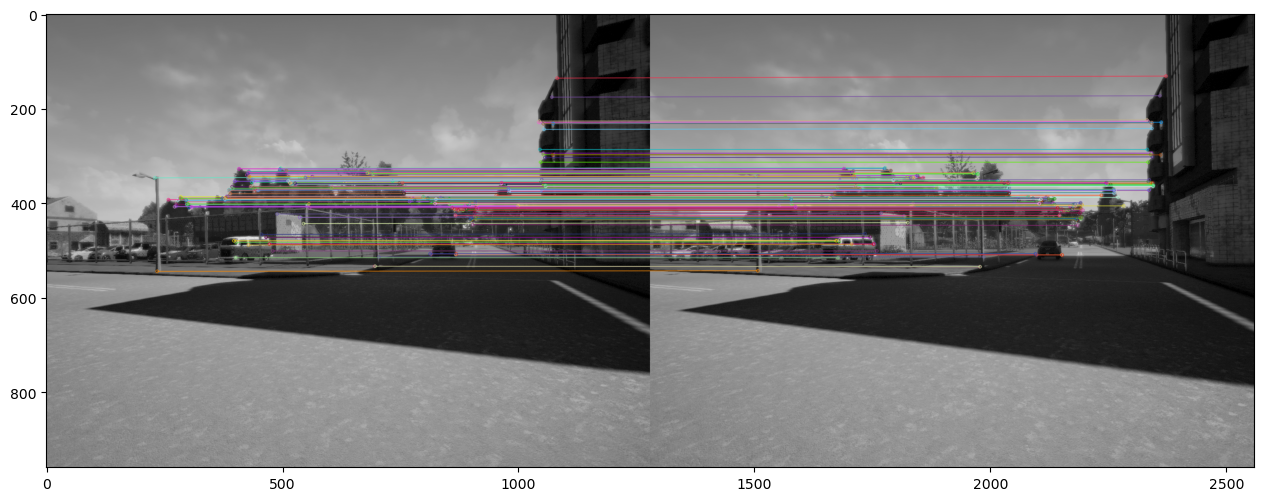

In [ ]:
# Визуализируйте первые n совпадений, поставьте n = None чтобы отобразить все совпадения
# установите filtering = True если хотите использовать фильтрацию совпадений, иначе поставьте False
n = None
filtering = True

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.2
    match = filter_matches_distance(match, dist_threshold)

print(len(match))

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

### 2.2 - Сопоставление признаков в каждой последующей паре изображений в наборе данных

**Задание**: Реализуйте сопоставление признаков для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

***Опционально***: Реализуйте фильтрацию соответствия, устанавливая пороговое значение расстояния для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

In [ ]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###

    
    ### END CODE HERE ###
    
    return matches

In [ ]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

In [ ]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###


    ### END CODE HERE ###
    
    return filtered_matches

In [ ]:
# Optional
dist_threshold = 0.2

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 0 and 1: 241


## 3 - Оценка траектории

На данном этапе есть все, чтобы реализовать визуальную одометрию. В этом разделе вы будете постепенно оценивать положение исследуя изменения на изображении с бортовой камеры, которые вызывает движение.

### 3.1 - Оценка движения камеры между парой изображений

**Задание**: Реализуйте оценку движения камеры по паре изображений. Вы можете использовать алгоритм оценки движения Perspective-n-Point (PnP) или Essential Matrix Decomposition.

- Если вы решите использовать PnP, вам понадобятся карты глубины кадра, и они предоставляются с обработчиком набора данных.


***Опционально***: Реализуйте оценку движения камеры с помощью PnP, PnP с RANSAC и Essential Matrix Decomposition. Посмотрите, как фильтрация совпадений по расстоянию меняет расчетное движение камеры. Вы видите разницу в различных подходах?

In [ ]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = [] # in 2D
    image2_points = [] # in 2D
    objectpoints = [] # in 3D
    
    ### START CODE HERE ###

    

    
    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [ ]:
# visualize_features(image, kp_list[0])

In [ ]:
i = 0

match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

In [ ]:
len(image1_points)

**Ожидаемый формат вывода**:

Убедитесь, что ваша предполагаемая матрица вращения и вектор перемещения имеют тот же формат, что и заданные начальные значения.

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

**Визуализация движения камеры**:
Вы можете использовать `visualize_camera_movement` доступный в локальном пакете. Эта функция визуализирует окончательные совпадения изображений из пары изображений, соединенных стрелкой, соответствующей направлению движения камеры. (when `is_show_img_after_mov = False`). Описание функции:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

In [ ]:
i=0
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 3.2 - Оценка траектории камеры

**Задание**: Реализуйте оценку траектории камеры с помощью визуальной одометрии. В частности, реализуйте оценку движения камеры для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

***Замечание***: Не забывайте, что пары изображений не являются независимыми друг от друга. i-я и (i + 1)-я пары изображений имеют общую часть

In [ ]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    trajectory = np.zeros((3, len(kp_list)))
    
    ### START CODE HERE ###

    ### END CODE HERE ###
    return trajectory

In [ ]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, filtered_matches, kp_list, k, depth_maps=depth_maps)

trajectory

In [ ]:
i = 20
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

**Expected Output**:

```
Camera location in point i is: 
 [[locXi]
 [locYi]
 [locZi]]```
 
 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

### Визуализируйте свои результаты


In [1]:
visualize_trajectory(trajectory)

NameError: ignored